# Projet MonGueuleTon

Nous allons dans ce notebook entrainer un classifieur d'image de nourriture, avec la base de donnée *Food-101*.   

Cette base de donnée est composée de 101 catégories d'images, chacune composés de 1000 exemple d'images.

## Imports

In [1]:
import pandas as pd
import requests
import glob
from io import BytesIO
import numpy as np
import os
import shutil
import pprint
import json


In [2]:
import fastai

fastai.__version__

'2.0.19'

In [3]:
from fastai import *
from fastai.vision import *
from fastai.imports import *

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Extraction des données


In [15]:
#!mkdir -p ../data
#!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz -P ../data
#!tar xzf ../data/food-101.tar.gz -C ../data

--2020-10-31 15:29:22--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Résolution de data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)… 129.132.52.162
Connexion à data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80… connecté.
requête HTTP transmise, en attente de la réponse… 302 Found
Emplacement : https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [suivant]
--2020-10-31 15:29:22--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connexion à data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 4996278331 (4,7G) [application/x-gzip]
Enregistre : «../data/food-101.tar.gz»

food-101.tar.gz     100%[===================>]   4,65G  48,9MB/s    ds 94s     

2020-10-31 15:30:56 (50,7 MB/s) - «../data/food-101.tar.gz» enregistré [4996278331/4996278331]



## Chargement des données

Chacune des 101 catégories ou classes sont stockés dans un dossier

In [4]:
!ls data

food-101  food-101.tar.gz


In [5]:
!ls data/food-101/

classes.txt  images  license_agreement.txt  meta  README.txt


- Les 5 premières catégories

In [4]:
!ls data/food-101/images | head -n 5

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare


Chemin vers les images 

In [6]:
path = Path('data/food-101/images')

In [7]:
from fastai.vision.all import *

In [8]:
#data = ImageDataBunch.from_folder(path, valid_pct=0.2,
#        ds_tfms=get_transforms(), size=224, num_workers=8, bs=64).normalize(imagenet_stats)

data = ImageDataLoaders.from_folder(path, valid_pct=0.2, 
    item_tfms=RandomResizedCrop(224),num_workers=8, bs=64, batch_tfms=Normalize.from_stats(*imagenet_stats))

In [10]:
#data.classes, data.c, len(data.train_ds), len(data.valid_ds)

# Entrainement du modèle

## Initialisation du Learning Rate

In [9]:
import torchvision.models as models

In [12]:
#learn = create_cnn(data, models.resnet34, metrics=error_rate,pretrained=True)
learn = cnn_learner(data, models.resnet34, metrics=error_rate, pretrained=True)

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.013182567432522774)

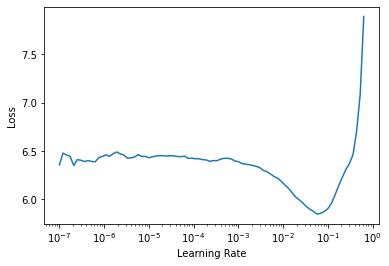

In [10]:
learn.lr_find()
#learn.recorder.plot(suggestion=True)

In [11]:
#learn = create_cnn(data, models.resnet34, metrics=error_rate, model_dir="../../prod")
#learn.model = torch.nn.DataParallel(learn.model)


In [15]:
lr = 0.015

In [16]:
learn.fit_one_cycle(8 , lr)

epoch,train_loss,valid_loss,error_rate,time
0,2.559440,2.140593,0.549406,03:05
1,2.552496,2.083103,0.535347,03:06
2,2.316155,1.790478,0.465446,03:07
3,2.175485,1.615735,0.420099,03:15
4,1.994075,1.392277,0.367475,03:14
5,1.774603,1.270176,0.335842,03:15
6,1.670123,1.192361,0.317871,03:13
7,1.630351,1.170672,0.312574,03:13


### Sauvegarde du modèle

In [13]:
model_name="resnet34-v2"

In [18]:
learn.save(f'{model_name}-stage-1')

Path('data/food-101/images/models/resnet34-v2-stage-1.pth')

## Entrainement des dernières couches
Commme nous utilisons une architecture Resnet34 pré-entrainé, nous allons faire du "Transfer Learning", et uniquement ré-entrainer les dernière couches afin de les spécialiser. 

In [19]:
learn.load(f'{model_name}-stage-1')

In [20]:
learn.unfreeze()


SuggestedLRs(lr_min=7.244359778724174e-09, lr_steep=1.047128517228657e-08)

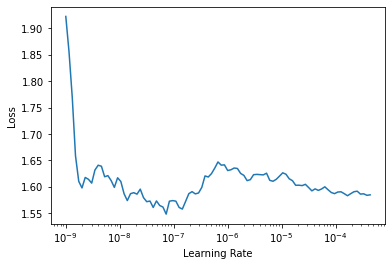

In [21]:
learn.lr_find(start_lr=1e-09, end_lr=1e-3)

In [28]:
#learn.recorder.plot(skip_end=10)


AttributeError: 'Learner' object has no attribute 'plot'

In [22]:
learn.fit_one_cycle(8, max_lr=slice(1e-8,1e-7))

epoch,train_loss,valid_loss,error_rate,time
0,2.198256,2.530545,0.604208,04:25
1,2.218120,2.220551,0.557178,04:27
2,1.917630,1.838132,0.471881,04:27
3,1.737006,1.355446,0.352376,04:28
4,1.595484,1.162130,0.311881,04:28
5,1.370663,1.004799,0.273218,04:27
6,1.235788,0.928767,0.250594,04:28
7,1.149756,0.910969,0.246980,04:28


In [23]:
learn.save(f'{model_name}-stage-2')

Path('data/food-101/images/models/resnet34-v2-stage-2.pth')

In [24]:
learn.load(f'{model_name}-stage-2');

## Interpretation

In [14]:
learn.load(f'{model_name}-stage-2');


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [1]:
interp.plot_top_losses(9, figsize=(15,11))


NameError: name 'interp' is not defined

In [24]:
interp.plot_confusion_matrix(figsize=(50,50), dpi=30)


NameError: name 'interp' is not defined

In [27]:
interp.most_confused(min_val=2)


[('filet_mignon', 'steak', 26),
 ('steak', 'filet_mignon', 26),
 ('tuna_tartare', 'beef_tartare', 23),
 ('chocolate_cake', 'chocolate_mousse', 21),
 ('pork_chop', 'filet_mignon', 20),
 ('pork_chop', 'grilled_salmon', 20),
 ('chocolate_mousse', 'chocolate_cake', 19),
 ('prime_rib', 'steak', 18),
 ('ravioli', 'lasagna', 18),
 ('breakfast_burrito', 'huevos_rancheros', 17),
 ('beef_tartare', 'tuna_tartare', 16),
 ('lobster_bisque', 'clam_chowder', 16),
 ('steak', 'pork_chop', 16),
 ('tiramisu', 'chocolate_mousse', 16),
 ('chicken_quesadilla', 'breakfast_burrito', 15),
 ('panna_cotta', 'chocolate_mousse', 15),
 ('ramen', 'pho', 15),
 ('ice_cream', 'frozen_yogurt', 14),
 ('pulled_pork_sandwich', 'hamburger', 14),
 ('sashimi', 'sushi', 14),
 ('tacos', 'nachos', 14),
 ('apple_pie', 'bread_pudding', 13),
 ('crab_cakes', 'falafel', 13),
 ('pork_chop', 'steak', 13),
 ('breakfast_burrito', 'omelette', 12),
 ('cheesecake', 'strawberry_shortcake', 12),
 ('greek_salad', 'beet_salad', 12),
 ('huevos_r

### Sauvegarde

In [88]:
final_model_name = f'{model_name}-final'

In [89]:
learn.save(final_model_name)

Path('data/food-101/images/models/resnet34-final.pth')

# Teste du modèle

### Chargement du modèle entrainé

In [15]:
from fastai.data.external import *

In [25]:
classif = load_learner("data/model2.pkl")

In [26]:
classif.predict("data/Hotdog.png")

('hot_dog',
 tensor(55),
 tensor([1.7369e-07, 1.0558e-07, 2.3832e-07, 9.6690e-08, 5.7385e-08, 2.5595e-08,
         2.0480e-08, 1.4756e-10, 1.3754e-08, 2.2323e-06, 2.6051e-07, 1.7747e-09,
         9.7692e-07, 2.4582e-07, 1.6717e-06, 1.0177e-08, 2.0900e-07, 4.7577e-06,
         9.1307e-09, 7.7743e-09, 1.8232e-09, 1.1913e-06, 8.5675e-07, 2.4264e-07,
         2.2438e-09, 6.1355e-07, 2.6697e-09, 1.3423e-06, 8.3579e-09, 3.3956e-07,
         6.2637e-09, 6.8279e-06, 3.2000e-08, 9.1072e-09, 2.5932e-08, 4.9562e-08,
         1.6495e-06, 3.7463e-08, 8.3145e-09, 1.1750e-06, 6.4861e-07, 9.7999e-08,
         4.1253e-08, 1.3878e-09, 6.9987e-09, 3.2061e-08, 2.3278e-06, 1.2596e-08,
         3.3557e-08, 1.6318e-06, 8.0110e-08, 3.0514e-09, 9.7041e-09, 1.5957e-05,
         4.5325e-08, 9.9993e-01, 2.5454e-08, 3.2759e-08, 8.2791e-08, 1.1993e-08,
         6.8319e-08, 6.3293e-07, 1.5317e-08, 1.1099e-05, 1.6177e-08, 4.7275e-08,
         8.3540e-10, 3.2458e-08, 1.5771e-08, 4.1686e-08, 2.8686e-10, 2.7139e-08,
   

In [24]:
img = charge_img("data/Guacamole-lime.jpg")

NameError: name 'charge_img' is not defined

In [18]:
pred_class,pred_idx,outputs = learn.predict("data/Guacamole-lime.jpg")
pred_class

'guacamole'

In [32]:
guacamole_url = "https://upload.wikimedia.org/wikipedia/commons/1/18/Guacamole-lime.jpg"

In [68]:
classif = load_learner('model.pkl')

In [76]:
def charge_img(url):
    response = requests.get(url)
    img = image_open(BytesIO(response.content))
    return img

In [77]:
def predict_two(url):
    img = charge_img(url)
    pred_class,pred_idx,outputs = classif.predict(img)
    res =  zip (classif.data.classes, outputs.tolist())
    predictions = sorted(res, key=lambda x:x[1], reverse=True)
    top_predictions = predictions[0:5]
    pprint.pprint( top_predictions)
    return img.resize(400)

In [78]:
predict_two(guacamole_url)

NameError: name 'image_open' is not defined

In [65]:
def predict_one(img):
    
    pred_class,pred_idx,outputs = classif.predict(img)
    res =  zip (classif.data.classes, outputs.tolist())
    predictions = sorted(res, key=lambda x:x[1], reverse=True)
    top_predictions = predictions[0:5]
    pprint.pprint( top_predictions)
    return img.resize(400)

In [69]:
predict_one("data/Guacamole-lime.jpg")

AttributeError: 'Learner' object has no attribute 'data'

# Vers la Production

To make our model available as a web app, we will need to save:
- final model
- list of class names

In [52]:
#learn.load("data/food-101/images/models/resnet34-final.pth")

FileNotFoundError: [Errno 2] No such file or directory: 'data/food-101/images/models/data/food-101/images/models/resnet34-final.pth.pth'

Remove existing model artifacts

In [84]:
#shutil.rmtree("../models",ignore_errors=True)

Copy the models stored locally to folder above

'/home/ubuntu/projects/food-classifier/notebooks/../models'

In [ ]:
#final_model_directory = os.getcwd()+ "/../models"

In [19]:
final_model_name='model2.pkl'

#### Export le modèle

In [20]:
#learn.export(final_model_name)

In [22]:
#learn.export(final_model_directory+f"/{final_model_name}")

In [39]:
!pwd

/home/sylla/Work/Projet/formation_projFinal/mongueuleton/entrainement


Save the list of classes

In [23]:
#with open('../models/classes.txt', 'w') as f:
#    json.dump(learn.data.classes,f)

## Teste POC déployement

In [141]:
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
#from fastai.vision.widgets import *

ERROR: voila 0.2.4 has requirement nbconvert<7,>=6.0.0, but you'll have nbconvert 5.6.1 which is incompatible.
ERROR: torchaudio 0.7.0 has requirement torch==1.7.0, but you'll have torch 1.6.0 which is incompatible.
ERROR: nbdev 1.1.5 has requirement fastcore>=1.3.1, but you'll have fastcore 1.3.0 which is incompatible.


/home/sylla/Work/Projet/formation_projFinal/mongueuleton/env_mgt/lib/python3.8/site-packages/fastbook/__init__.py:22: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [140]:
from fastai.vision.widgets import *
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()

In [139]:
!pip install voila
!jupyter serverextension enable voila --sys-prefix

     |████████████████████████████████| 1.9 MB 8.3 MB/s eta 0:00:01
     |████████████████████████████████| 196 kB 144.6 MB/s eta 0:00:01
Enabling: voila
- Writing config: /home/sylla/Work/Projet/formation_projFinal/mongueuleton/env_mgt/etc/jupyter
    - Validating...
      voila 0.2.4 OK
